# Movie Recommendations

Your company would like to start a movie studio and is asking us to recommend the best way froward. The main objective of this project is to produce three actionable recommendations for your company to take into consideration. With these recommendations your company can create their own successful movie studio.

# Goals

Here are the questions I would like to answer:
* What genres perform the best? 
* What is the ideal release date?
* Are there certain people involved in the most successful movies (directors, actors, or writers)?

## Success Metric

We will measure how much of the production budget was made back. A film is generally considered a success if it makes back at least 2x its budget. Therefore we will be judging success by ROI and looking for ROI of at least 100% to be considered a success.

ROI = ((worldwide gross - production budget) / production budget) x 100

## Data

* BOM Movie Gross (csv) - Used for movie revenue for our ROI metric
* IMDB (Database) - Used for movie details
* Movie Budgets (csv) - Used to assess a movie's budget to factor into the ROI metric

## Methods

In [64]:
# import libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# connect database
conn = sqlite3.connect('../zippedData/im.db')

In [3]:
# review tables in the database (make sure bom is still added)
pd.read_sql("""

SELECT name
FROM sqlite_master
WHERE type = "table"

""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers
8,bom_movie_gross
9,rt_movie_info


### Clean Movie Basics Data

In [4]:
movie_basics=pd.read_sql("""SELECT * FROM movie_basics""",conn)

In [5]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [6]:
# Add success metric to movie_basics
movies_summary=pd.read_sql("""
SELECT movie, production_budget, worldwide_gross, genres, runtime_minutes  
FROM movie_budgets budget
INNER JOIN movie_basics basic
ON TRIM(LOWER(budget.movie))=TRIM(LOWER(basic.primary_title))
""",conn)

In [7]:
movies_summary

,movie,production_budget,worldwide_gross,genres,runtime_minutes
0,Avatar,"$425,000,000","$2,776,345,279",Horror,93.0
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875","Action,Adventure,Fantasy",136.0
2,Dark Phoenix,"$350,000,000","$149,762,350","Action,Adventure,Sci-Fi",113.0
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963","Action,Adventure,Sci-Fi",141.0
4,Avengers: Infinity War,"$300,000,000","$2,048,134,200","Action,Adventure,Sci-Fi",149.0
...,...,...,...,...,...
3886,Cure,"$10,000","$94,596",None,NaN
3887,Bang,"$10,000",$527,None,NaN
3888,Newlyweds,"$9,000","$4,584","Comedy,Drama",95.0
3889,Red 11,"$7,000",$0,"Horror,Sci-Fi,Thriller",77.0


In [8]:
# Add to SQL data
movies_summary.to_sql('movies_summary',conn, if_exists='replace')

3891

In [9]:
movies_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3891 entries, 0 to 3890
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              3891 non-null   object 
 1   production_budget  3891 non-null   object 
 2   worldwide_gross    3891 non-null   object 
 3   genres             3818 non-null   object 
 4   runtime_minutes    3397 non-null   float64
dtypes: float64(1), object(4)
memory usage: 152.1+ KB


### Add Success Metric to movies_summary table

In [10]:
movies_summary

,movie,production_budget,worldwide_gross,genres,runtime_minutes
0,Avatar,"$425,000,000","$2,776,345,279",Horror,93.0
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875","Action,Adventure,Fantasy",136.0
2,Dark Phoenix,"$350,000,000","$149,762,350","Action,Adventure,Sci-Fi",113.0
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963","Action,Adventure,Sci-Fi",141.0
4,Avengers: Infinity War,"$300,000,000","$2,048,134,200","Action,Adventure,Sci-Fi",149.0
...,...,...,...,...,...
3886,Cure,"$10,000","$94,596",None,NaN
3887,Bang,"$10,000",$527,None,NaN
3888,Newlyweds,"$9,000","$4,584","Comedy,Drama",95.0
3889,Red 11,"$7,000",$0,"Horror,Sci-Fi,Thriller",77.0


In [11]:
movies_summary['production_budget'] = movies_summary['production_budget'].replace({'\$': '', ',': ''}, regex=True).astype(float)
movies_summary['worldwide_gross'] = movies_summary['worldwide_gross'].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [12]:
#Calculate net profit and add to DF
movies_summary['net_profit'] = movies_summary['worldwide_gross'] - movies_summary['production_budget']

In [13]:
#Calculate ROI and add to DF
movies_summary['roi'] = (movies_summary['net_profit'] / movies_summary['production_budget']) * 100

In [14]:
# Format net_profit with commas for thousands separator
movies_summary['net_profit'] = movies_summary['net_profit'].apply(lambda x: f"{x:,.2f}")

# Format ROI as percentage (with two decimal places)
movies_summary['roi'] = movies_summary['roi'].apply(lambda x: f"{x:,.2f}%")

In [15]:
# Format production_budget and worldwide_gross with commas for thousands separator
movies_summary['production_budget'] = movies_summary['production_budget'].apply(lambda x: f"${x:,.0f}")
movies_summary['worldwide_gross'] = movies_summary['worldwide_gross'].apply(lambda x: f"${x:,.0f}")

In [16]:
movies_summary.to_sql('movies_summary',conn, if_exists='replace')

3891

## What genres perform the best? 


In [17]:
# Create data frame with only relevant columns
genre_analysis=movies_summary[['genres','roi']]
genre_analysis

,genres,roi
0,Horror,553.26%
1,"Action,Adventure,Fantasy",154.67%
2,"Action,Adventure,Sci-Fi",-57.21%
3,"Action,Adventure,Sci-Fi",324.38%
4,"Action,Adventure,Sci-Fi",582.71%
...,...,...
3886,None,845.96%
3887,None,-94.73%
3888,"Comedy,Drama",-49.07%
3889,"Horror,Sci-Fi,Thriller",-100.00%


In [18]:
# Check for null values
genre_analysis.isna().any()

genres     True
roi       False
dtype: bool

In [19]:
# Drop null values
genre_analysis=genre_analysis.dropna()

In [20]:
#Confirm null values were dropped
genre_analysis.isna().any()

genres    False
roi       False
dtype: bool

In [21]:
# Split genres into lists
genre_analysis = genre_analysis.copy()
genre_analysis['genres'] = genre_analysis['genres'].str.split(',') 
 # Normalize the data
genre_analysis = genre_analysis.explode('genres').reset_index(drop=True)

In [22]:
genre_analysis

,genres,roi
0,Horror,553.26%
1,Action,154.67%
2,Adventure,154.67%
3,Fantasy,154.67%
4,Action,-57.21%
...,...,...
7951,Sci-Fi,-100.00%
7952,Thriller,-100.00%
7953,Drama,-100.00%
7954,Horror,-100.00%


In [23]:
#Change percentages to string so we can calculate mean
genre_analysis['roi'] = genre_analysis['roi'].astype(str).str.replace(',', '').str.replace('%', '').astype(float)

genre_analysis_plot = genre_analysis.groupby('genres')['roi'].mean().reset_index()
genre_analysis_plot = genre_analysis_plot.sort_values(by='roi', ascending=False)

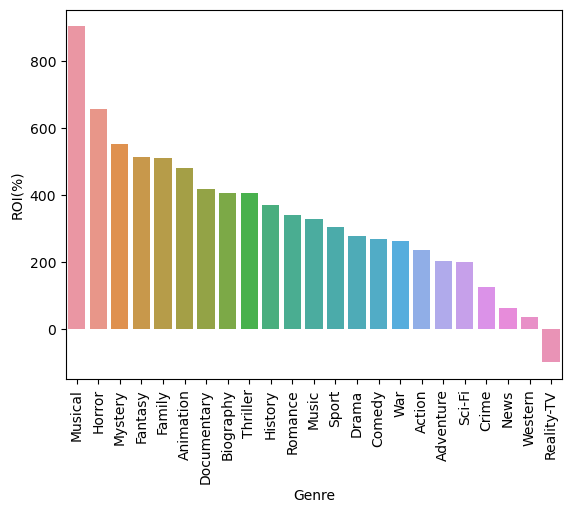

In [24]:
sns.barplot(x='genres', y='roi', data=genre_analysis_plot)
plt.ylabel('ROI(%)')
plt.xlabel('Genre')
plt.xticks(rotation=90)
plt.show()

In [104]:
genre_analysis_plot

,genres,roi
13,Musical,904.484167
11,Horror,656.162993
14,Mystery,554.376310
9,Fantasy,513.667177
8,Family,511.464381
2,Animation,479.892614
6,Documentary,418.098327
3,Biography,406.126863
20,Thriller,405.938831
10,History,369.160306


## Ideal Run Time?

In [25]:
#Create data frame of just relevant columns
runtime_analysis=movies_summary[['runtime_minutes','roi']]

In [26]:
# See summary
runtime_analysis.runtime_minutes.value_counts().describe()

count    170.000000
mean      19.982353
std       25.013954
min        1.000000
25%        3.000000
50%        9.000000
75%       27.000000
max      160.000000
Name: count, dtype: float64

In [27]:
runtime_analysis

,runtime_minutes,roi
0,93.0,553.26%
1,136.0,154.67%
2,113.0,-57.21%
3,141.0,324.38%
4,149.0,582.71%
...,...,...
3886,NaN,845.96%
3887,NaN,-94.73%
3888,95.0,-49.07%
3889,77.0,-100.00%


In [28]:
#Check for nulls
runtime_analysis.isna().sum()

runtime_minutes    494
roi                  0
dtype: int64

In [29]:
#Drop nulls
runtime_analysis=runtime_analysis.dropna()

In [30]:
#Remove % and convert roi to float
runtime_analysis.loc[:, 'roi'] = runtime_analysis['roi'].astype(str).str.replace(',', '').str.replace('%', '').astype(float)/100

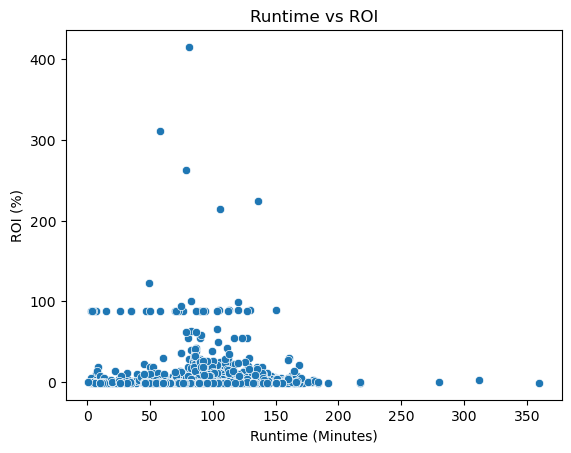

In [31]:
#Plot
sns.scatterplot(x='runtime_minutes', y='roi', data=runtime_analysis)
plt.title('Runtime vs ROI')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('ROI (%)')
plt.show()

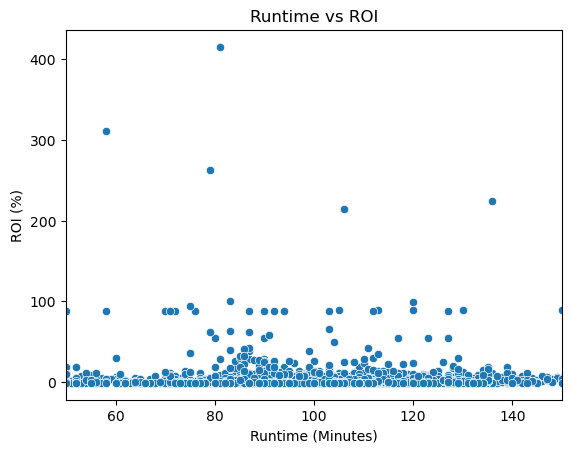

In [32]:
#Zoom in on plot
sns.scatterplot(x='runtime_minutes', y='roi', data=runtime_analysis)
plt.title('Runtime vs ROI')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('ROI (%)')
plt.xlim(50, 150)
plt.show()

In [58]:
#Let's inspect the top 10 results
sorted_runtime = runtime_analysis.sort_values(by='roi', ascending=False)
sorted_runtime.head(10)

,runtime_minutes,roi
3826,81.0,415.5647
3561,58.0,311.3543
3824,79.0,262.9216
3473,136.0,224.0
3732,106.0,214.3846
3421,49.0,123.2779
3475,83.0,100.7595
3825,120.0,99.0
3747,75.0,94.576
3171,150.0,89.8936


In [61]:
sorted_runtime_top=sorted_runtime.head(10)
sorted_runtime_top.describe()

,runtime_minutes
count,10.000000
mean,93.700000
std,33.193205
min,49.000000
25%,76.000000
50%,82.000000
75%,116.500000
max,150.000000


## Are there certain directors that consistently produce the best ROI?

In [62]:
#Make new data set with only relevant columns
pd.read_sql("""

SELECT name
FROM sqlite_master
WHERE type = "table"

""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers
8,bom_movie_gross
9,rt_movie_info


In [34]:
pd.read_sql("""
SELECT *
FROM movie_basics
""", conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [35]:
pd.read_sql("""
SELECT *
FROM persons
""", conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [36]:
pd.read_sql("""
SELECT *
FROM principals
""", conn)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,None,None
1028184,tt9692684,4,nm6009913,writer,writer,None


In [37]:
pd.read_sql("""
SELECT *
FROM directors
""", conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [38]:
pd.read_sql("""
SELECT *
FROM persons
""", conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [39]:
directors_analysis=pd.read_sql("""

SELECT basic.movie_id, sum.movie, p.primary_name as director, sum.roi  
FROM movies_summary sum

INNER JOIN movie_basics basic
ON TRIM(LOWER(sum.movie))=TRIM(LOWER(basic.primary_title))

INNER JOIN directors d
ON d.movie_id=basic.movie_id

INNER JOIN persons p
on d.person_id = p.person_id
""",conn)

In [40]:
directors_analysis

,movie_id,movie,director,roi
0,tt1775309,Avatar,Atsushi Wada,553.26%
1,tt1775309,Avatar,Atsushi Wada,553.26%
2,tt1298650,Pirates of the Caribbean: On Stranger Tides,Rob Marshall,154.67%
3,tt1298650,Pirates of the Caribbean: On Stranger Tides,Rob Marshall,154.67%
4,tt1298650,Pirates of the Caribbean: On Stranger Tides,Rob Marshall,154.67%
...,...,...,...,...
25404,tt1880418,Newlyweds,Edward Burns,-49.07%
25405,tt7837402,Red 11,Robert Rodriguez,-100.00%
25406,tt7837402,Red 11,Robert Rodriguez,-100.00%
25407,tt2107644,A Plague So Pleasant,Benjamin Roberds,-100.00%


In [41]:
#Check for null vaues
directors_analysis.isna().sum()

movie_id    0
movie       0
director    0
roi         0
dtype: int64

In [42]:
#Check for duplicates
directors_analysis.duplicated().sum()

21158

In [43]:
#Delete duplicates
directors_analysis = directors_analysis.drop_duplicates(subset='movie_id')

In [44]:
directors_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3595 entries, 0 to 25407
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3595 non-null   object
 1   movie     3595 non-null   object
 2   director  3595 non-null   object
 3   roi       3595 non-null   object
dtypes: object(4)
memory usage: 140.4+ KB


In [45]:
#Format ROI column
directors_analysis.loc[:, 'roi'] = directors_analysis['roi'].astype(str).str.replace(',', '').str.replace('%', '').astype(float)/100

In [46]:
#Group by director and calculate mean roi
director_roi = directors_analysis.groupby('director')['roi'].mean().reset_index()

In [47]:
#Sort by ROI
director_roi_sorted = director_roi.sort_values(by='roi', ascending=False)

In [48]:
director_roi_sorted

,director,roi
443,Chris Lofing,415.5647
2604,Sébastien Lifshitz,311.3543
29,Adnan A. Shaikh,224.0
2587,Sujit Mondal,224.0
1437,Karthik Chandan,123.2779
...,...,...
2635,Terron R. Parsons,-1.0
2256,Robert Heath,-1.0
778,Edward E. Romero,-1.0
777,Edward Drake,-1.0


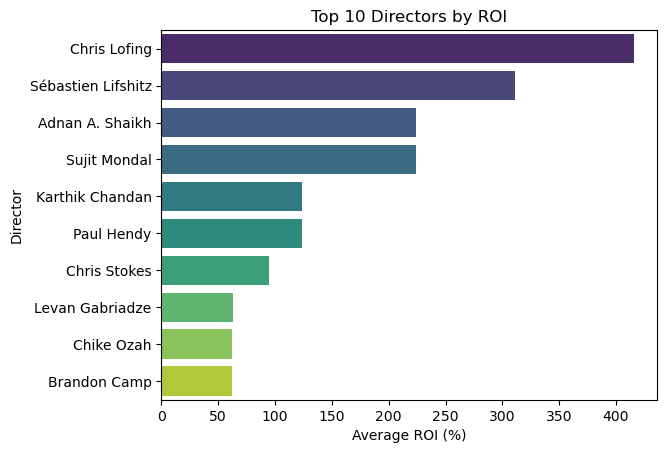

In [49]:
#Plot top directors
top_directors = director_roi_sorted.head(10)
sns.barplot(x='roi', y='director', data=top_directors, palette='viridis')
plt.xlabel('Average ROI (%)')
plt.ylabel('Director')
plt.title('Top 10 Directors by ROI')
plt.show()

In [50]:
#Taking into account how many movies they directed
director_analysis = (
    directors_analysis.groupby('director')
    .agg(
        avg_roi=('roi', 'mean'), 
        movie_count=('movie_id', 'count')
    )
    .reset_index()
)

In [74]:
director_analysis.movie_count.describe()

count    2921.000000
mean        1.230743
std         0.674506
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         8.000000
Name: movie_count, dtype: float64

In [75]:
director_analysis

,director,avg_roi,movie_count
0,Aaron Agrasanchez,0.6542,1
1,Aaron Alon,-0.342,1
2,Aaron Hann,-0.995,1
3,Aaron Horvath,4.1621,1
4,Aaron Schnobrich,0.1753,1
...,...,...,...
2916,Zhigang Yang,0.3568,1
2917,Zoran Lisinac,-0.9871,1
2918,Zsófia Szilágyi,2.9446,1
2919,Zuri Rinpoche,0.8894,1


In [78]:
filtered_directors = director_analysis[director_analysis['movie_count'] >= 3]

In [94]:
sorted_filtered_directors = filtered_directors.sort_values(by='avg_roi', ascending=False)
top_sorted_filtered_directors=sorted_filtered_directors.head(10)

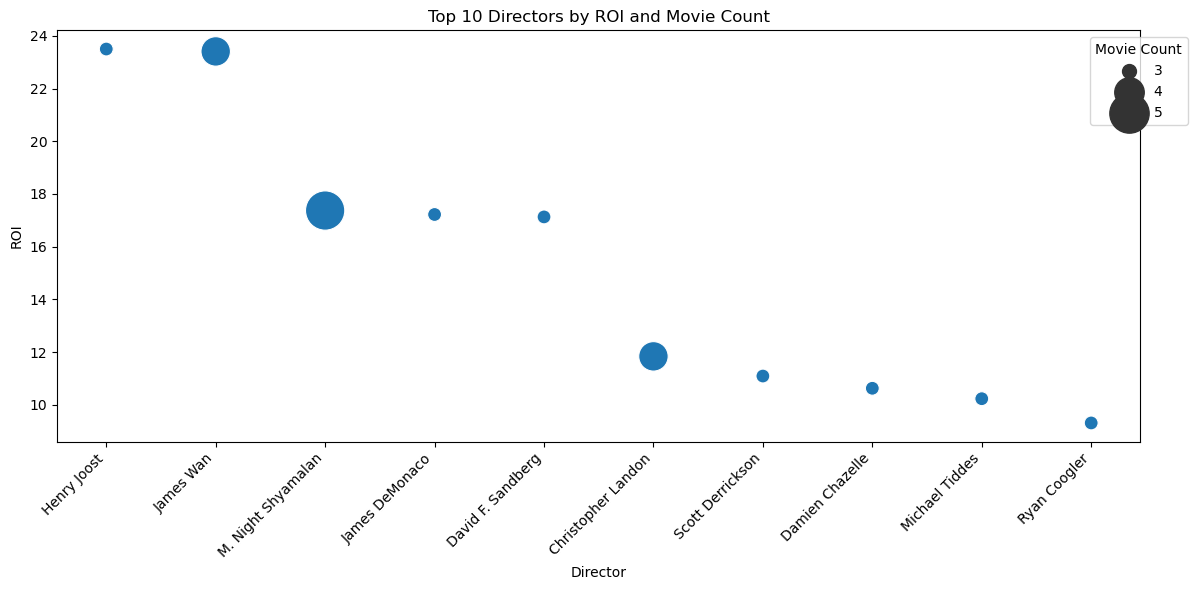

In [102]:
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=top_sorted_filtered_directors, 
    x='director', 
    y='avg_roi', 
    size='movie_count', 
    sizes=(100, 800),  # Adjust size range
    legend='full'  # Enables legend for size
)

# Customize the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Director')
plt.ylabel('ROI')
plt.title('Top 10 Directors by ROI and Movie Count')

# Customize the legend
handles, labels = scatter.legend_.legend_handles, scatter.legend_.texts
scatter.legend_.set_title("Movie Count")
scatter.legend_.set_bbox_to_anchor((1.05, 1))  # Place legend outside plot
plt.tight_layout()
plt.show()

In [103]:
top_sorted_filtered_directors

,director,avg_roi,movie_count
1002,Henry Joost,23.5014,3
1101,James Wan,23.4105,4
1623,M. Night Shyamalan,17.37196,5
1077,James DeMonaco,17.222167,3
630,David F. Sandberg,17.1299,3
479,Christopher Landon,11.8378,4
2405,Scott Derrickson,11.0913,3
555,Damien Chazelle,10.6266,3
1825,Michael Tiddes,10.2311,3
2339,Ryan Coogler,9.310633,3


## Results

### Business Recommendation 1

To optimize the selection of movies, it is recommended to focus on genres such as Musicals, Horror, and Mystery, as these categories have shown the highest average returns on investment (ROI). Musicals have the highest ROI at 904.48, followed by Horror at 656.16, and Mystery at 554.38. Targeting films within these genres could lead to greater profitability.

### Business Recommendation 2

It is advisable to focus on movies with a runtime between 50 and 150 minutes, with an ideal target around 93.7 minutes. This range has been associated with higher audience engagement and satisfaction, making it a strategic choice for film production and distribution.

### Business Recommendation 3

Focusing on directors with proven track records in delivering high ROI, such as Henry Joost, James Wan, and M. Night Shyamalan, is recommended. Their past works have consistently contributed to successful films, making them valuable assets for future projects in terms of both creativity and box-office performance.